# ORHS project template

This notebook is a template that can be used as a starting point for project work. It contains several necessary python imports (useful libraries of code that we will use) and other functions that will do useful things for us.  

## What is jupyter notebook?

This template is a [jupyter notebook](https://jupyter.org/) this is nothing more than a series of "cells", blocks of content that can be either text (like this cell) or code (like the cells below). This is a useful way to keep track of computational experimentation. 

There are two main rules with jupyter notebooks:

1. To execute the content of a cell, you just need to type `shift-enter`
2. The order of execution matters!

## How to add to this template

You can create a new cell by pressing `<esc>` from inside an existing cell and then typing `a` to insert a cell to **a**bove the current one or `b` to inert one **b**elow the current one.

In [1]:
# import useful things here

import copy
from mantid.simpleapi import *
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

In [13]:
# load neutron data

inputDataPath = "LAM_lite_48746.nxs" #this is where to find the input data.
neutronData = LoadNexusProcessed(Filename=inputDataPath) #this command loads the data into a "mantid workspace" just a container for neutron data


Cannot find period log. Logs will be not be filtered by current period
Cannot find periods log. Logs will be not be filtered by current period


In [14]:
# this cell defines helper functions to move between input data and images derived from
# these.

# need a function to convert from pixel ID to i,j coordinates to build an image
def rowCol(specID):
    
    #there are two detectors. 
    #each detector is a 3 x 3 (= 9) array of modules

    NRowModule = 3      # number of rows of modules in a detector
    NColumnModule = 3   # number of columns of modules in a detector
    NModule = NRowModule*NColumnModule # total number of modules in a detector

    #Each module is comprised of 32 x 32 (=1024) array of pixels

    NRowPixel = 32 # number of rows of pixels in a module
    NColumnPixel = 32 # number of columns of pixels in a module
    NPixel = NRowPixel*NColumnPixel # total number of pixels in a module

    #in the following, coordinates are generically given by (i,j) tuples where
    #i is the row index and j is the column index.

    # step 1: useful to get coordinates i,j of modules.

    #row and column indices for the module containing specID are obtained from
    idModule = specID // NPixel
    jModule = idModule // NColumnModule # column index of module containing specID
    iModule = idModule % NRowModule # row index of module containing specID

    #step 2: equivalently get row and column indices for the pixel within the module:
    firstPixelInModule = idModule*NPixel
    idPixel = int(specID - firstPixelInModule) #ID running from 0 to 1024 for each pixel in a module
    jPixel =  idPixel // NColumnPixel
    iPixel = specID % NRowPixel
    
    #step 3: Transform coordinates to create the image I want. This has the west and east banks side by side 
    #(with west on left) and both detectors as viewed from the sample position. 
    #The resultant images will be 96x192 (=18432) pixels
    
    #need to remap module indices to put the columns of modules in the right order corresponding to 
    #desired viewing direction (from sample)
    jModuleMap=[3,4,5,0,1,2]
    jModule = jModuleMap.index(jModule)
    
    j = jModule*NColumnPixel+jPixel
    i = (iModule)*NRowPixel+iPixel

    #image row index increases from top to bottom, versus convention of images being bottom to top, so need to invert
    i = NRowPixel*NRowModule-i-1
    
    return i,j

def imageFactory(xMin,xMax,wsName):
    #This takes a mantid workspace name, creates a single slice of data between the specified 
    #min/max x-values and returns an ndarray containing integrated Y values in the slice
    #the ndarray is indexed to act as a regular image (origin top left, i indexes rows
    # (increasing top to bottom), while j indexes columns (increasing left to right)

    #choose a binning parameter that gives only one bin
    xBin = np.abs(xMax-xMin)

    #create a workspace with only the requested slice in it
    tempSlice = Rebin(InputWorkspace=wsName,
                     Params=f'{xMin},{xBin},{xMax}')
    # build image from slice of data
    ws = mtd['tempSlice']
    
    image = np.empty((96,192))  #empty array to hold data
    for spec in range(ws.getNumberHistograms()):
    
        i,j = rowCol(spec) #returns indices
        
        image[i,j] = ws.dataY(spec)[0] #assign y value of pixel to image array

    return image

def coordSpecIDMap(wsName):
    #This builds an ndarray that is identical to imageFactory, but populates this with the 
    #input spectrum numbers. The resultant array provides a convenient way to recover the
    #spectrum ID of any pair of image (i,j) coordinates.

    ws = mtd[wsName]
    
    image = np.empty((96,192))  #empty array to hold data
    for spec in range(ws.getNumberHistograms()):
    
        i,j = int(spec) #returns indices
        
        image[i,j] = ws.dataY(spec)[0] #assign y value of pixel to image array

    return image


In [15]:
#in this cell, create useful functions for masking pixels. These will all return a copy of the original input data with the mask applied,
#thus leaving the original data unchanged.

def maskGrid(inputImage,gridWidth=1):
    #This is a function to mask (by setting to zero) all pixels that lie on the module edge
    #these edges are clearly visible in the images as a glowing grid.

    outputImage = copy.deepcopy(inputImage)
    
    #process rows
    for row in range(96):
        
        if np.logical_or((row%32)<=gridWidth,(row%32)>=32-gridWidth):
            outputImage[row,:]=0
    
    #columns
    for col in range(192):
        if np.logical_or((col%32)<=gridWidth,(col%32)>=32-gridWidth):
            outputImage[:,col]=0

    return outputImage

def threshMask(inputImage,thresh):
    #a simple threshold mask, currently defined as a multiple of the mean y-value of the input image

    outputImage = copy.deepcopy(inputImage)
    mask_vals = inputImage > thresh*inputImage.mean()
    outputImage[mask_vals]=0

    return outputImage

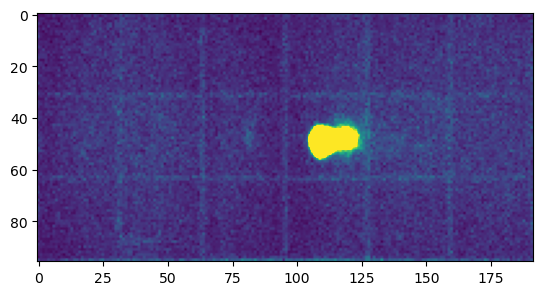

In [18]:
#create and plot image with sliced between limiting x-values
xMin = 1.22
xMax = 1.27
image = imageFactory(xMin,xMax,'neutronData') #create our image, called "image" using the function imageFactory
plt.imshow(image,vmax=0.02) #vmax parameter sets limit on y-value to plot in image

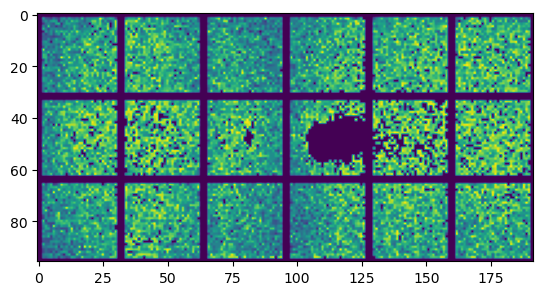

In [19]:
# apply the two of masks to this
mask = maskGrid(image)
mask = threshMask(mask,0.3) #this is setup so that masks are combined additively 
plt.imshow(mask)